#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 1 - Supervised Deep Learning

## General overview
In this homework you will learn how to implement and test simple neural network models for solving supervised problems. It is divided in two tasks.

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 

* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of handwritten digits (MNIST). 

In both cases, but especially for the classification problem, you should explore the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. For the image classification task, you can also implement more advanced convolutional architectures and explore feature visualization techniques to better understand how the deep network is encoding information at different processing layers.

#


## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework.If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length should not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: implement basic regression and classification tasks
*	2 pt: explore advanced optimizers and regularization methods 
*	1 pt: optimize hyperparameters using grid/random search and cross-validation
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields



## Deadline
The complete homework (notebook + report) must be submitted through Moodle at least 10 days before the chosen exam date.


# Regression task

## Guidelines

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

## Dataset

The following cell of code will download the dataset and make it available in the local folder `regression_dataset`. There are two files:

* `regression_dataset/train_data.csv`
* `regression_dataset/test_data.csv`

Use them to train and test your model. Each row contains two values, respactively the input and the target (label).

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold, train_test_split
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv 

--2020-12-26 12:28:12--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv.1’

train_data.csv.1    100%[===================>]   3.69K  --.-KB/s    in 0s      

2020-12-26 12:28:13 (94.4 MB/s) - ‘regression_dataset/train_data.csv.1’ saved [3776/3776]

--2020-12-26 12:28:13--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘r

How to load the data:

In [ ]:
train_df = pd.read_csv('regression_dataset/train_data.csv')

How to get a specific sample:

In [ ]:
sample_index = 0
input = train_df.iloc[sample_index]['input']
label = train_df.iloc[sample_index]['label']

print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

SAMPLE AT INDEX 0
INPUT: -4.787870188090535
LABEL: -1.216803599957529


All training points:

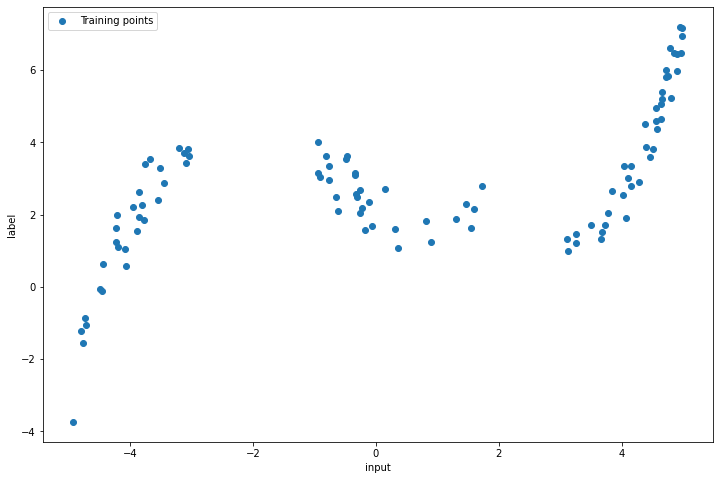

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()


In [ ]:
# Basic network definition
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No, p):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        p - dropout probability
        """
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.do = nn.Dropout(p=p)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.Sigmoid()
        
    def forward(self, x, additional_out=False):
        x = self.act(self.do(self.fc1(x)))
        x1 = self.act(self.do(self.fc2(x)))
        x2 = self.out(x1)
        return x2

In [ ]:
all_train_losses = []
all_val_losses = []
avg_train_loss = []
avg_val_loss = []
models = []

### TRAINING LOOP
def training_loop(data, k, batch_size, lr, epochs, p):

    # cross validation loop
    kfold = KFold(n_splits=k, random_state=0)
    X_train = data.df['input']
    y_train = data.df['label']
    fold = 0

    for train_idcs, val_idcs in kfold.split(X_train, y_train):
        print('#################')
        print(f'# FOLD {fold}')
        print('#################')
        fold += 1
        X_train_fold = X_train[train_idcs]
        X_val_fold = X_train[val_idcs]
        y_train_fold = y_train[train_idcs]
        y_val_fold = y_train[val_idcs]

        # create dataloaders for the new training and validation datasets
        train_tuples = list(zip(X_train_fold,y_train_fold))
        val_tuples = list(zip(X_val_fold,y_val_fold))
        train_dataframe = pd.DataFrame(train_tuples, columns=['input','label'])
        val_dataframe = pd.DataFrame(val_tuples, columns=['input','label'])
        train_dataset = RegressionDataset(train_dataframe, transform=composed_transform)
        val_dataset = RegressionDataset(val_dataframe, transform=composed_transform)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        val_dataloader  = DataLoader(val_dataset,  batch_size=len(val_dataset), shuffle=False, num_workers=0)

        # create a model
        torch.manual_seed(0)
        Ni = 1
        Nh1 = 128
        Nh2 = 256
        No = 1
        net = Net(Ni, Nh1, Nh2, No, p)
        net.to(device)

        # Define the optimizer
        optimizer = optim.Adam(net.parameters(), lr=lr)

        models.append(net)

        train_loss_log = []
        val_loss_log = []
        num_epochs = epochs
        for epoch_num in range(num_epochs):
          print('#################')
          print(f'# EPOCH {epoch_num}')
          print('#################')


          ### TRAIN
          train_loss= []
          net.train() # Training mode (e.g. enable dropout)
          for sample_batched in train_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = net(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Backpropagation
            net.zero_grad()
            loss.backward()

            # Update the weights
            optimizer.step()

            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)

          # Save average train loss
          train_loss = np.mean(train_loss)
          print(f"AVERAGE TRAIN LOSS: {train_loss}")
          train_loss_log.append(train_loss)

          ### VALIDATION
          val_loss= []
          net.eval() # Evaluation mode (e.g. disable dropout)
          with torch.no_grad(): # Disable gradient tracking
            for sample_batched in val_dataloader:
              # Move data to device
              x_batch = sample_batched[0].to(device)
              label_batch = sample_batched[1].to(device)
              # Forward pass
              out = net(x_batch)

              # Compute loss
              loss = loss_fn(out, label_batch)

              # Save val loss for this batch
              loss_batch = loss.detach().cpu().numpy()
              val_loss.append(loss_batch)

            # Save average validation loss
            val_loss = np.mean(val_loss)
            print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
            val_loss_log.append(val_loss)

          # remember all losses for this model
          if epoch_num == num_epochs - 1:
            avg_train_loss.append(np.mean(train_loss_log))
            # only condiser the last then validation losses to find the best model
            avg_val_loss.append(np.mean(val_loss_log[-10:]))
            all_train_losses.append(train_loss_log)
            all_val_losses.append(val_loss_log)

    best_model_idx = np.argmin(avg_val_loss)
    print(f"BEST TRAIN LOSS: {avg_train_loss[best_model_idx]}")
    print(f"BEST VAL LOSS: {avg_val_loss[best_model_idx]}")
    return best_model_idx, all_train_losses[best_model_idx], all_val_losses[best_model_idx]

In [ ]:
# define Dataset
class RegressionDataset(Dataset):

  def __init__(self, data, transform=None):
    """
    Args:
        data (string or dataframe): Path to the csv file or dataframe containing data.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.transform = transform
    # Read the file and store the content in a pandas DataFrame
    if isinstance(data, str):
      self.df = pd.read_csv(data)
    else:
      self.df = data

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    sample = (row.input, row.label)
    if self.transform:
        sample = self.transform(sample)
    return sample

In [ ]:
# define Transforms
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.Tensor([x]).float(),
                torch.Tensor([y]).float())


# Initialize Datasets
composed_transform = transforms.Compose([ToTensor()])
train_dataset = RegressionDataset('regression_dataset/train_data.csv', transform=composed_transform)
test_dataset  = RegressionDataset('regression_dataset/test_data.csv', transform=composed_transform)

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Define the loss function
loss_fn = nn.MSELoss()

grid_search = True

# simply run network with default parameters
if not grid_search:
  best_model_idx, _, _ = training_loop(train_dataset, 10, 20, 0.01, 200, 0)
  best_model = models[best_model_idx]

if grid_search:
  grid_models = []
  # perform a grid search over batch size, learning rate, dropout probability
  for b_size in [5, 15, 20]:
    for lr in [0.1, 0.01, 0.001]:
      for do_p in [0, 0.2, 0.4]:
        print('GRID PATTERN')
        best_model_idx, train_loss_log, val_loss_log = training_loop(train_dataset, 10, b_size, lr, 150, do_p)
        best_model = models[best_model_idx]
        model_info = {'model': best_model, 'batch_size': b_size, 'lr': lr, 'dropout': do_p, 
                      'val_loss': val_loss_log, 'train_loss': train_loss_log}
        grid_models.append(model_info)
  # choose best model
  idx = np.argmin([np.mean(model['val_loss'][-10:]) for model in grid_models])
  best_model = grid_models[idx]
  print(f"BEST TRAIN LOSS: {np.mean(best_model['train_loss'])}")
  print(f"BEST VAL LOSS: {np.mean(best_model['val_loss'])}")
  b_size = best_model['batch_size']
  lr = best_model['lr']
  do = best_model['dropout']
  print(f'Best Hyperparams: batch_size: {b_size}; learning rate: {lr}; dropout: {do}')

net = best_model['model']

Training device: cuda
GRID PATTERN
#################
# FOLD 0
#################
Network initialized
#################
# EPOCH 0
#################
AVERAGE TRAIN LOSS: 45.239158630371094
AVERAGE VAL LOSS: 20.044971466064453
#################
# EPOCH 1
#################
AVERAGE TRAIN LOSS: 9.874796867370605
AVERAGE VAL LOSS: 5.466023921966553
#################
# EPOCH 2
#################


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Streaming output truncated to the last 5000 lines.
AVERAGE VAL LOSS: 1.2935246229171753
#################
# EPOCH 56
#################
AVERAGE TRAIN LOSS: 2.6532821655273438
AVERAGE VAL LOSS: 1.2142404317855835
#################
# EPOCH 57
#################
AVERAGE TRAIN LOSS: 2.637098550796509
AVERAGE VAL LOSS: 1.2682727575302124
#################
# EPOCH 58
#################
AVERAGE TRAIN LOSS: 2.6442410945892334
AVERAGE VAL LOSS: 1.293426752090454
#################
# EPOCH 59
#################
AVERAGE TRAIN LOSS: 2.7066941261291504
AVERAGE VAL LOSS: 1.3188915252685547
#################
# EPOCH 60
#################
AVERAGE TRAIN LOSS: 3.0191428661346436
AVERAGE VAL LOSS: 1.3206005096435547
#################
# EPOCH 61
#################
AVERAGE TRAIN LOSS: 2.7839837074279785
AVERAGE VAL LOSS: 1.4257363080978394
#################
# EPOCH 62
#################
AVERAGE TRAIN LOSS: 2.7299673557281494
AVERAGE VAL LOSS: 1.4078370332717896
#################
# EPOCH 63
#################
AVERAG

In [ ]:
### Save regression network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_state_dict = net.state_dict()
# Save the state dict to a file
torch.save(net_state_dict, 'reg_parameters.torch')

### Reload the network state
# First initialize the network (if not already done)
if do is None:
  do = 0.0
net = Net(1, 128, 256, 1, do)
# Load the state dict previously saved
net_state_dict = torch.load('reg_parameters.torch')
# Update the network parameters
net.load_state_dict(net_state_dict)
net.to(device)

Network initialized


Net(
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (do): Dropout(p=0, inplace=False)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
  (act): Sigmoid()
)

In [ ]:
# Plot losses without grid search
#plt.figure(figsize=(12,8))
#plt.semilogy(all_train_losses[best_model_idx], label='Train loss')
#plt.semilogy(all_val_losses[best_model_idx], label='Validation loss')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.grid()
#plt.legend()
#plt.show()

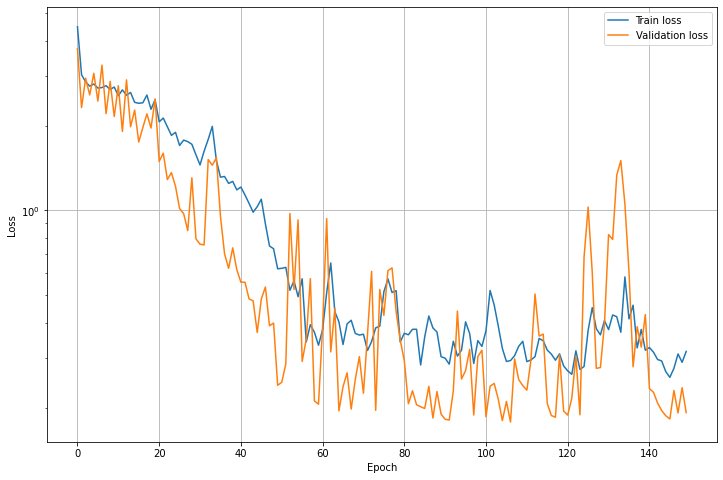

In [ ]:
# Plot losses for grid search
plt.figure(figsize=(12,8))
plt.semilogy(best_model['train_loss'], label='Train loss')
plt.semilogy(best_model['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

Input shape: torch.Size([1000, 1])
Output shape: torch.Size([1000, 1])


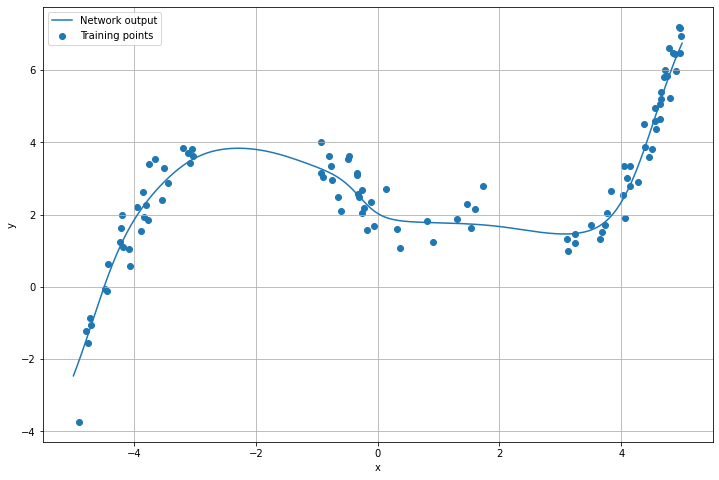

In [ ]:
# Look at learned model
# Input vector
x_vec = torch.linspace(-5,5,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)
print(f"Input shape: {x_vec.shape}")

# Network output
with torch.no_grad():
  if not grid_search:
    y_vec = best_model(x_vec)
  else:
    y_vec = best_model['model'](x_vec)
print(f"Output shape: {y_vec.shape}")

# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

# Plot output
plt.figure(figsize=(12,8))
plt.plot(x_vec, y_vec, label='Network output')
plt.scatter(train_dataset.df.input, train_dataset.df.label, label='Training points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()



In [ ]:
# Testing
test_dataset  = RegressionDataset('regression_dataset/test_data.csv', transform=composed_transform)
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)

if not grid_search:
  net = best_model
else:
  net = best_model['model']

all_inputs = []
all_outputs = []
all_labels = []
net.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
  for sample_batched in test_dataloader:
    # Move data to device
    x_batch = sample_batched[0].to(device)
    label_batch = sample_batched[1].to(device)
    # Forward pass
    out = net(x_batch)
    # Save outputs and labels
    all_inputs.append(x_batch)
    all_outputs.append(out)
    all_labels.append(label_batch)
# Concatenate all the outputs and labels ina single tensor
all_inputs  = torch.cat(all_inputs)
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels)

test_loss = loss_fn(all_outputs, all_labels)
print(f"AVERAGE TEST LOSS: {test_loss}")

AVERAGE TEST LOSS: 0.2236904799938202


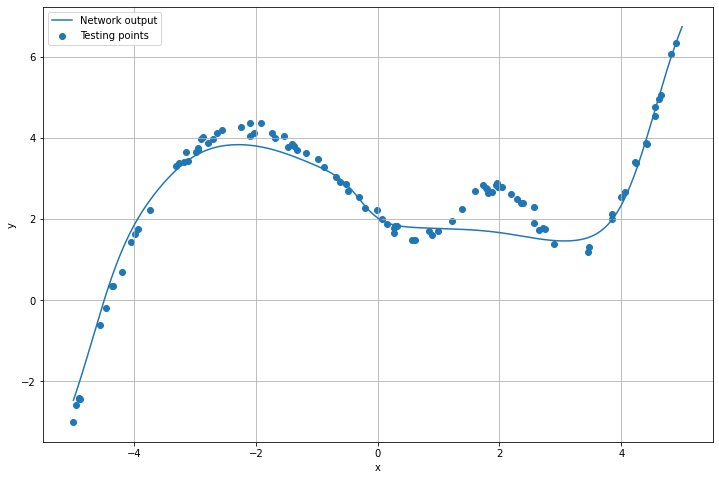

In [ ]:
# print test results as learned model and testing points
# Look at learned model

# Plot output
plt.figure(figsize=(12,8))
plt.plot(x_vec, y_vec, label='Network output')
plt.scatter(test_dataset.df.input, test_dataset.df.label, label='Testing points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

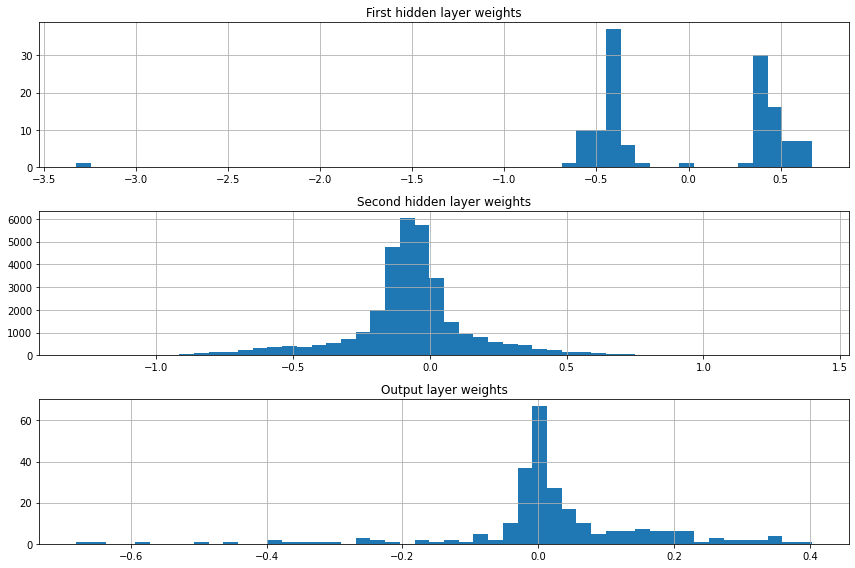

In [ ]:
# Visualize weights
# First hidden layer
h1_w = net.fc1.weight.data.cpu().numpy()
h1_b = net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.fc2.weight.data.cpu().numpy()
h2_b = net.fc2.bias.data.cpu().numpy()

# Output layer
out_w = net.out.weight.data.cpu().numpy()
out_b = net.out.bias.data.cpu().numpy()

# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

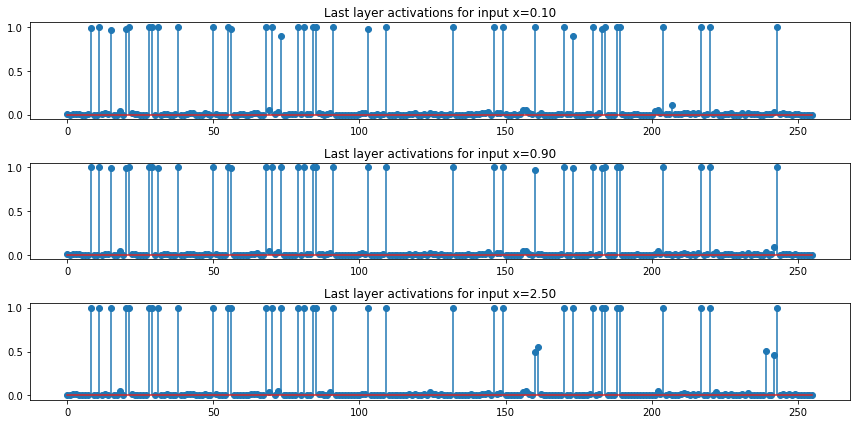

In [ ]:
# Visualize Activation Profiles
def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook  
hook_handle = net.fc2.register_forward_hook(get_activation)

### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([0.1]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0.9]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([2.5]).float().to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()

# Classification task

## Guidelines

* The goal is to train a neural network that maps an input image (hand-written digit) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

## Dataset

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import os
import pandas as pd

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

Download the dataset:

In [ ]:
# Data preprocessing
# transform input images to tensors
to_tensor = torchvision.transforms.ToTensor()

class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        return to_tensor(sample)

class Flatten(object) :
    """Convert sample to Tensors."""

    def __call__(self, sample):
        return torch.flatten(sample)


composed_transform = transforms.Compose([ToTensor(), Flatten()])
composed_transform_cnn = transforms.Compose([ToTensor()])


In [ ]:
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True, transform=composed_transform)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True, transform=composed_transform)

Extracting classifier_data/MNIST/raw/train-images-idx3-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


How to get an image and the corresponding label:

In [ ]:
#sample_index = 0
#image = train_dataset[sample_index][0].squeeze()
#label = train_dataset[sample_index][1]

#fig = plt.figure(figsize=(8,8))
#plt.imshow(image, cmap='Greys')
#print(f"SAMPLE AT INDEX {sample_index}")
#print(f"LABEL: {label}")

The output of the dataset is a PIL Image, a python object specifically developed to manage and process images. PyTorch supports this format, and there are useful transforms available natively in the framework: https://pytorch.org/docs/stable/torchvision/transforms.html

If you want, you can easily convert a PIL image to a numpy array and entirely ignore the PIL object:

In [ ]:
#image_numpy = np.array(image)

#print(f'Numpy array shape: {image_numpy.shape}')
#print(f'Numpy array type: {image_numpy.dtype}')

To transform a PIL Image directly to a PyTorch tensor, instead:

In [ ]:
# doesn't run, because you included transform in dataset download, so is already a tensor not an image
#to_tensor = torchvision.transforms.ToTensor()
#image_tensor = to_tensor(image)

#print(f'PyTorch tensor shape: {image_tensor.shape}')
#print(f'PyTorch tensor type: {image_tensor.dtype}')

In [ ]:
# split training dataset with sklearn train_test_split
X = [i[0] for i in train_dataset]
y = [i[1] for i in train_dataset]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# construct datasets
train_dataset = [(x, y) for x, y in zip(X_train, y_train)]
val_dataset = [(x, y) for x, y in zip(X_val, y_val)]

In [ ]:
# create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=0)
val_dataloader  = DataLoader(val_dataset,  batch_size=len(val_dataset), shuffle=False, num_workers=0)
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)

In [ ]:
# Basic network definition
class ClassNet(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        # need to figure out the output sizes!! Do these even go together??
        # parameters: channel, kernel size, stride
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.fc3 = nn.Linear(in_features=Nh2, out_features=No)
        self.out = nn.Softmax()
        self.act = nn.Sigmoid()
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x1 = self.act(self.fc2(x))
        x2 = self.out(self.fc3(x1))
        return x2

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Initialize the basic network
torch.manual_seed(0)
Ni = 28 * 28
Nh1 = 256
Nh2 = 128
No = 10
net = ClassNet(Ni, Nh1, Nh2, No)
net.to(device)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-2)

Training device: cuda
Network initialized


In [ ]:
# training and validation loop
### TRAINING LOOP
num_epochs = 50
train_loss_log = []
val_loss_log = []
for epoch_num in range(num_epochs):
  print('#################')
  print(f'# EPOCH {epoch_num}')
  print('#################')

  ### TRAIN
  train_loss= []
  net.train() # Training mode (e.g. enable dropout)
  for sample_batched in train_dataloader:
    # Move data to device
    x_batch = sample_batched[0].to(device)
    label_batch = sample_batched[1].to(device)

    # Forward pass
    out = net(x_batch)

    # Compute loss
    loss = loss_fn(out, label_batch)

    # Backpropagation
    net.zero_grad()
    loss.backward()

    # Update the weights
    optimizer.step()

    # Save train loss for this batch
    loss_batch = loss.detach().cpu().numpy()
    train_loss.append(loss_batch)

  # Save average train loss
  train_loss = np.mean(train_loss)
  print(f"AVERAGE TRAIN LOSS: {train_loss}")
  train_loss_log.append(train_loss)

  ### VALIDATION
  val_loss= []
  net.eval() # Evaluation mode (e.g. disable dropout)
  with torch.no_grad(): # Disable gradient tracking
    for sample_batched in val_dataloader:
      # Move data to device
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)

      # Forward pass
      out = net(x_batch)

      # Compute loss
      loss = loss_fn(out, label_batch)

      # Save val loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      val_loss.append(loss_batch)

    # Save average validation loss
    val_loss = np.mean(val_loss)
    print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
    val_loss_log.append(val_loss)

#################
# EPOCH 0
#################


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


AVERAGE TRAIN LOSS: 1.5788472890853882
AVERAGE VAL LOSS: 1.5355064868927002
#################
# EPOCH 1
#################
AVERAGE TRAIN LOSS: 1.5330660343170166
AVERAGE VAL LOSS: 1.531787395477295
#################
# EPOCH 2
#################
AVERAGE TRAIN LOSS: 1.5242632627487183
AVERAGE VAL LOSS: 1.525924801826477
#################
# EPOCH 3
#################
AVERAGE TRAIN LOSS: 1.5204033851623535
AVERAGE VAL LOSS: 1.5213229656219482
#################
# EPOCH 4
#################
AVERAGE TRAIN LOSS: 1.518528699874878
AVERAGE VAL LOSS: 1.525592565536499
#################
# EPOCH 5
#################
AVERAGE TRAIN LOSS: 1.5150268077850342
AVERAGE VAL LOSS: 1.5200073719024658
#################
# EPOCH 6
#################
AVERAGE TRAIN LOSS: 1.5124340057373047
AVERAGE VAL LOSS: 1.5134773254394531
#################
# EPOCH 7
#################
AVERAGE TRAIN LOSS: 1.510834813117981
AVERAGE VAL LOSS: 1.511800765991211
#################
# EPOCH 8
#################
AVERAGE TRAIN LOSS: 1.51078522

In [ ]:
### Save classification network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_state_dict = net.state_dict()
# Save the state dict to a file
torch.save(net_state_dict, 'class_parameters.torch')

### Reload the network state
# First initialize the network (if not already done)
net = ClassNet(Ni, Nh1, Nh2, No)
# Load the state dict previously saved
net_state_dict = torch.load('class_parameters.torch')
# Update the network parameters
net.load_state_dict(net_state_dict)
net.to(device)

Network initialized


ClassNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (out): Softmax(dim=None)
  (act): Sigmoid()
)

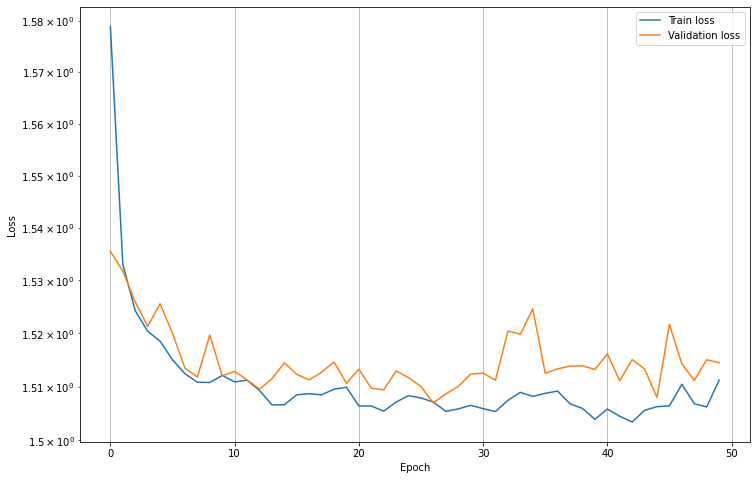

In [ ]:
# plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
# test loss
all_inputs = []
all_outputs = []
all_labels = []
net.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
  for sample_batched in test_dataloader:
    # Move data to device
    x_batch = sample_batched[0].to(device)
    label_batch = sample_batched[1].to(device)
    # Forward pass
    out = net(x_batch)
    # Save outputs and labels
    all_inputs.append(x_batch)
    all_outputs.append(out)
    all_labels.append(label_batch)
# Concatenate all the outputs and labels in a single tensor
all_inputs  = torch.cat(all_inputs)
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels)

test_loss = loss_fn(all_outputs, all_labels)
print(f"AVERAGE TEST LOSS: {test_loss}")

Training device: cuda
AVERAGE TEST LOSS: 1.516635537147522


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
# Get test accuracy
all_output_classes = torch.zeros(all_labels.shape).to(device)
output_list = [torch.argmax(output).item() for output in all_outputs]
all_output_classes = torch.FloatTensor(output_list).to(device)
tot_correct_out = (all_output_classes == all_labels).sum()
test_accuracy = 100 * tot_correct_out / len(all_labels)
print(f"TEST ACCURACY: {test_accuracy:.2f}%")

TEST ACCURACY: 94.45%


LABEL: 7; PRED: 7.0
LABEL: 2; PRED: 2.0
LABEL: 1; PRED: 1.0
LABEL: 0; PRED: 0.0
LABEL: 4; PRED: 4.0


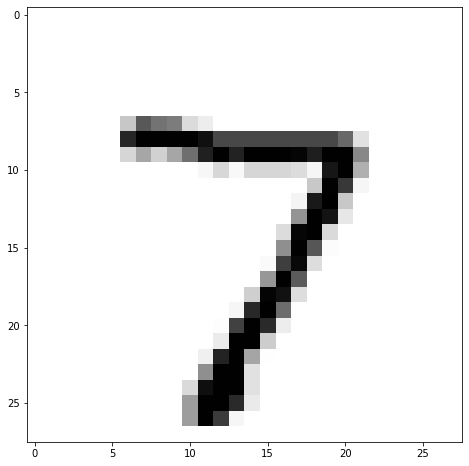

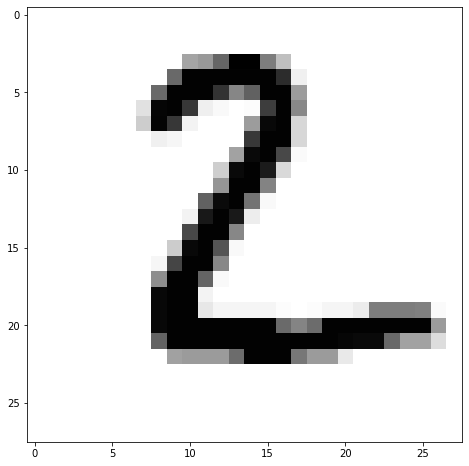

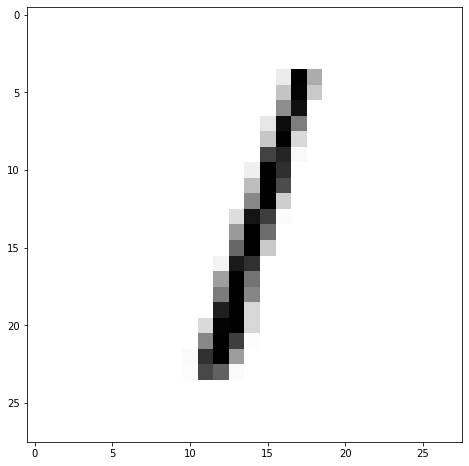

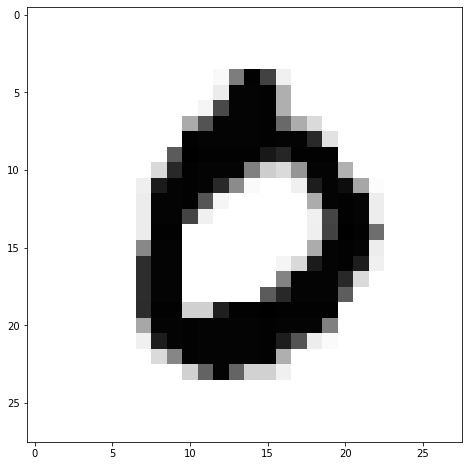

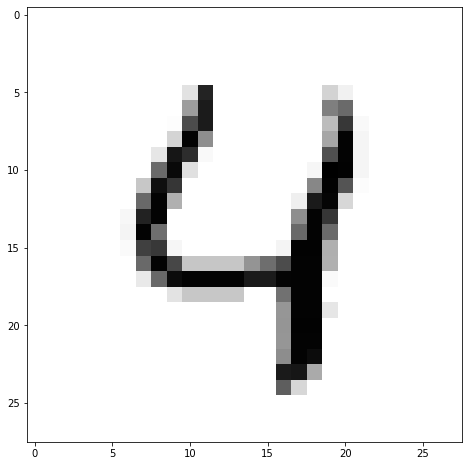

In [ ]:
# plot some results
for input, output, label in zip(all_inputs[:5], all_output_classes[:5], all_labels[:5]):
  input = torch.reshape(input, (28, 28))
  ig = plt.figure(figsize=(8,8))
  input = input.cpu().numpy()
  plt.imshow(input, cmap='Greys')
  print(f"LABEL: {label}; PRED: {output}")

CNN

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import os
import pandas as pd

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import random

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Data preprocessing
# transform input images to tensors
to_tensor = torchvision.transforms.ToTensor()

class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        return to_tensor(sample)

class Flatten(object) :
    """Convert sample to Tensors."""

    def __call__(self, sample):
        return torch.flatten(sample)


composed_transform = transforms.Compose([ToTensor(), Flatten()])
composed_transform_cnn = transforms.Compose([ToTensor()])

# Prepare the data
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True, transform=composed_transform_cnn)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True, transform=composed_transform_cnn)

# split training dataset with sklearn split_train_test
X = [i[0] for i in train_dataset]
y = [i[1] for i in train_dataset]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# construct datasets
train_dataset = [(x, y) for x, y in zip(X_train, y_train)]
val_dataset = [(x, y) for x, y in zip(X_val, y_val)]

# create the dataloaders
val_dataloader  = DataLoader(val_dataset,  batch_size=len(val_dataset), shuffle=False, num_workers=0)
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)

In [ ]:
# CNN structure
class CNNet(nn.Module):
    
    def __init__(self, k, Nh1, Nh2, No, do_p):
        """
        k - kernel size for convolutional layers
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        do_p - dropout probability
        """
        super(CNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, k)
        self.conv2 = nn.Conv2d(6, 16, k)
        self.fc1 = nn.Linear(16 * 4 * 4, Nh1)
        self.fc2 = nn.Linear(Nh1, Nh2)
        self.fc3 = nn.Linear(Nh2, No)
        self.do = nn.Dropout(p=do_p)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.relu(self.conv1(x))
        x0 = F.max_pool2d(x, (2, 2))
        x1 = F.relu(self.conv2(x0))
        x2 = F.max_pool2d(x1, 2)
        x2 = x2.view(-1, self.num_flat_features(x2))
        x2 = F.relu(self.do(self.fc1(x2)))
        x2 = F.relu(self.do(self.fc2(x2)))
        x2 = self.fc3(x2)
        return x2, x, x1

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

def initialize_cnn(k, Nh1, Nh2, No, do_p):
  # Initialize the CNN
  torch.manual_seed(0)
  cnn = CNNet(k, Nh1, Nh2, No, do_p)
  cnn.to(device)
  return cnn

Training device: cuda


In [ ]:
# training and validation loop
### TRAINING LOOP

def train_cnn(num_epochs, lr, b_size):

  train_dataloader = DataLoader(train_dataset, batch_size=b_size, shuffle=True, num_workers=0)

  # Define the optimizer
  optimizer = optim.Adagrad(cnn.parameters(), lr=lr)

  for epoch_num in range(num_epochs):
    print('#################')
    print(f'# EPOCH {epoch_num}')
    print('#################')

    ### TRAIN
    train_loss= []
    cnn.train() # Training mode (e.g. enable dropout)
    for sample_batched in train_dataloader:
      # Move data to device
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)

      # Forward pass
      out, _, _ = cnn(x_batch)

      # Compute loss
      loss = loss_fn(out, label_batch)

      # Backpropagation
      cnn.zero_grad()
      loss.backward()

      # Update the weights
      optimizer.step()

      # Save train loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)

    ### VALIDATION
    val_loss= []
    cnn.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # Disable gradient tracking
      for sample_batched in val_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out, _, _ = cnn(x_batch)

        # Compute loss
        loss = loss_fn(out, label_batch)

        # Save val loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        val_loss.append(loss_batch)

      # Save average validation loss
      val_loss = np.mean(val_loss)
      print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
      val_loss_log.append(val_loss)

In [ ]:
train_loss_log = []
val_loss_log = []

random_search = True
if not random_search:
  # call the training loop
  cnn = initialize_cnn(5, 120, 84, 10, 0.2)
  train_cnn(50, 0.01, 100)


if random_search:
  # perform random search on dropout, batch size, learning rate
  # evaluate 10 random models
  grid_models = []
  batch_sizes = [4, 20, 100, 200, 500, 1000, 2000]
  for i in range(10):
    print(f'RANDOM PATTERN {i}')
    train_loss_log = []
    val_loss_log = []

    random.seed(i)
    # get dropout possibility between 0 and 0.5
    do = random.random() / 2
    # get batch size
    b = random.randrange(0, 7)
    batch_size = batch_sizes[b]
    # get learning rate btw 0 and 1
    lr = random.random()
    Nh1 = 120
    Nh2 = 84

    cnn = initialize_cnn(5, Nh1, Nh2, 10, do)
    train_cnn(30, lr, batch_size)

    model_info = {'model': cnn, 'batch_size': batch_size, 'lr': lr, 'dropout': do, 'kernel size': 5, 
                  'Nh1': Nh1, 'Nh2': Nh2, 'val_loss': val_loss_log, 'train_loss': train_loss_log}
    grid_models.append(model_info)
  
  # choose the best model
  idx = np.argmin([np.mean(model['val_loss'][-10:]) for model in grid_models])
  best_model = grid_models[idx]
  print(f"BEST TRAIN LOSS: {np.mean(best_model['train_loss'])}")
  print(f"BEST VAL LOSS: {np.mean(best_model['val_loss'])}")
  for x in best_model:
      print (x,':',best_model[x])
        



RANDOM PATTERN 0
#################
# EPOCH 0
#################
AVERAGE TRAIN LOSS: 0.7084352970123291
AVERAGE VAL LOSS: 0.15655440092086792
#################
# EPOCH 1
#################
AVERAGE TRAIN LOSS: 0.21738843619823456
AVERAGE VAL LOSS: 0.10845322906970978
#################
# EPOCH 2
#################
AVERAGE TRAIN LOSS: 0.1639218032360077
AVERAGE VAL LOSS: 0.09004265069961548
#################
# EPOCH 3
#################
AVERAGE TRAIN LOSS: 0.14464305341243744
AVERAGE VAL LOSS: 0.08609796315431595
#################
# EPOCH 4
#################
AVERAGE TRAIN LOSS: 0.1242750808596611
AVERAGE VAL LOSS: 0.07797779142856598
#################
# EPOCH 5
#################
AVERAGE TRAIN LOSS: 0.1117621511220932
AVERAGE VAL LOSS: 0.07238520681858063
#################
# EPOCH 6
#################
AVERAGE TRAIN LOSS: 0.10203161090612411
AVERAGE VAL LOSS: 0.06709425151348114
#################
# EPOCH 7
#################
AVERAGE TRAIN LOSS: 0.0940956324338913
AVERAGE VAL LOSS: 0.06174210458993

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_state_dict = cnn.state_dict()
# Save the state dict to a file
torch.save(net_state_dict, 'cnn_parameters.torch')
### Reload the network state
# First initialize the network (if not already done)
cnn = initialize_cnn(5, 120, 84, 10, best_model['dropout'])
# Load the state dict previously saved
net_state_dict = torch.load('cnn_parameters.torch')
# Update the network parameters
cnn.load_state_dict(net_state_dict)
cnn.to(device)

CNNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (do): Dropout(p=0.42221092576252406, inplace=False)
)

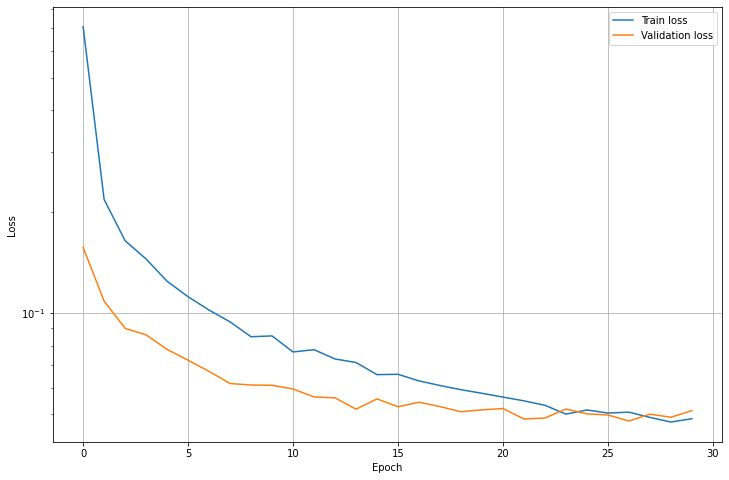

In [ ]:
# plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Test CNN
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
# test loss
all_inputs = []
all_outputs = []
all_labels = []
cnn.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
  for sample_batched in test_dataloader:
    # Move data to device
    x_batch = sample_batched[0].to(device)
    label_batch = sample_batched[1].to(device)
    # Forward pass
    out, _, _ = cnn(x_batch)
    # Save outputs and labels
    all_inputs.append(x_batch)
    all_outputs.append(out)
    all_labels.append(label_batch)
# Concatenate all the outputs and labels in a single tensor
all_inputs  = torch.cat(all_inputs)
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels)

test_loss = loss_fn(all_outputs, all_labels)
print(f"AVERAGE TEST LOSS: {test_loss}")

# Get test accuracy
all_output_classes = torch.zeros(all_labels.shape).to(device)
assert (len(all_output_classes) == len(all_labels))
assert (len(all_outputs) == len(all_labels))
output_list = [torch.argmax(output).item() for output in all_outputs]
all_output_classes = torch.FloatTensor(output_list).to(device)
tot_correct_out = (all_output_classes == all_labels).sum()
test_accuracy = 100 * tot_correct_out / len(all_labels)
print(f"TEST ACCURACY: {test_accuracy:.2f}%")

Training device: cuda
AVERAGE TEST LOSS: 0.045891422778367996
TEST ACCURACY: 98.94%


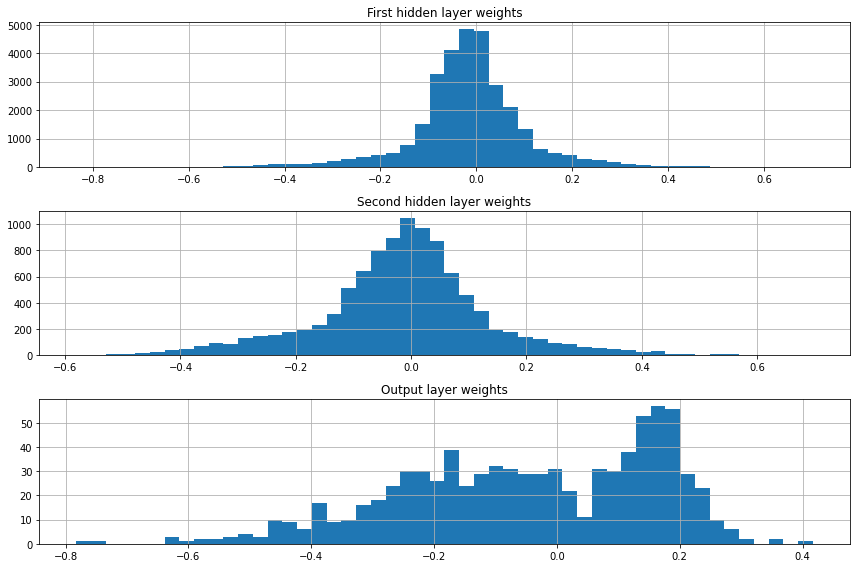

In [ ]:
# Visualize weights fully connected layers

# First hidden layer
h1_w = cnn.fc1.weight.data.cpu().numpy()
h1_b = cnn.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = cnn.fc2.weight.data.cpu().numpy()
h2_b = cnn.fc2.bias.data.cpu().numpy()

# Output layer
out_w = cnn.fc3.weight.data.cpu().numpy()
out_b = cnn.fc3.bias.data.cpu().numpy()

# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

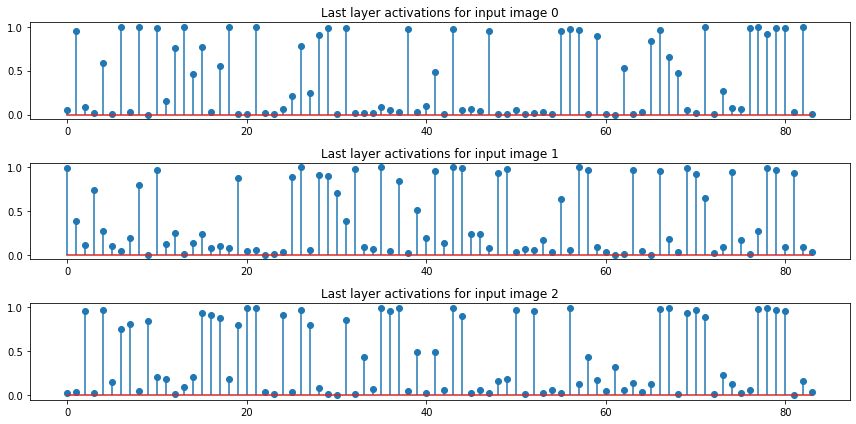

In [ ]:
# Visualize Activation Profiles of fully connected layers
def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook  
hook_handle = cnn.fc2.register_forward_hook(get_activation)

### Analyze activations
cnn = cnn.to(device)
cnn.eval()
with torch.no_grad():
    x1 = all_inputs[0].unsqueeze(0)
    y1, _, _ = cnn(x1)
    z1 = activation
    x2 = all_inputs[1].unsqueeze(0)
    y2, _, _ = cnn(x2)
    z2 = activation
    x3 = all_inputs[2].unsqueeze(0)
    y3, _, _ = cnn(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.squeeze().cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input image 0')
axs[1].stem(z2.squeeze().cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input image 1')
axs[2].stem(z3.squeeze().cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input image 2')
plt.tight_layout()
plt.show()

(6, 1, 5, 5)
(16, 6, 5, 5)


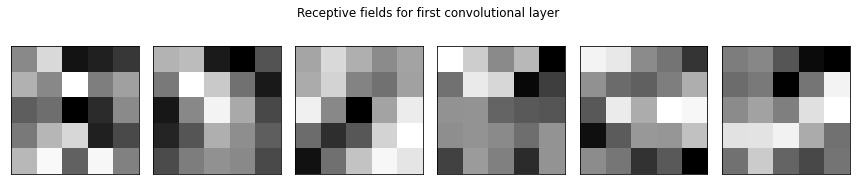

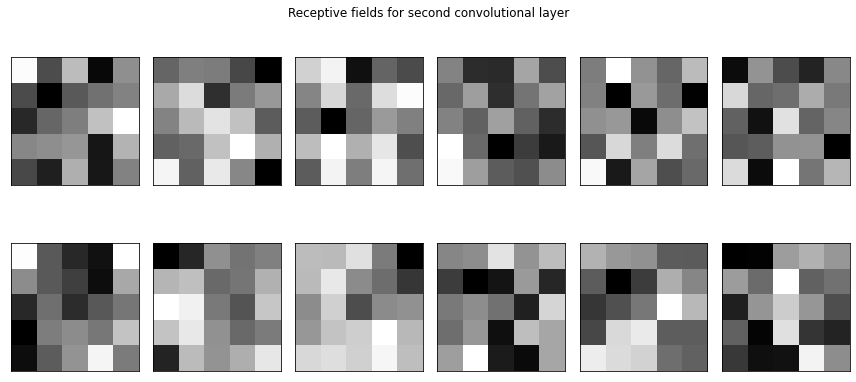

In [ ]:
# Visualize receptive fields
# First hidden layer
h1_w = cnn.conv1.weight.data.cpu().numpy()
h1_b = cnn.conv1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = cnn.conv2.weight.data.cpu().numpy()
h2_b = cnn.conv2.bias.data.cpu().numpy()

# normalize filter values to 0-1 so we can visualize them
print(h1_w.shape)
print(h2_w.shape)
f_min, f_max = h1_w.min(), h1_w.max()

# plot fall 6 filters from first conv layer
n_filters = 6
fig, axs = plt.subplots(1, 6, figsize=(12, 3))
fig.suptitle('Receptive fields for first convolutional layer')
for i in range(n_filters):
  # get the filter
  f = h1_w[i, :, :, :]
  ax = axs[i]
  # specify subplot and turn of axis
  ax.set_xticks([])
  ax.set_yticks([])
  # plot filter channel in grayscale
  ax.imshow(f[0, :, :], cmap='gray')
# show the figure
fig.tight_layout()
plt.show()


f_min, f_max = h2_w.min(), h2_w.max()
h2_w = (h2_w - f_min) / (f_max - f_min)

# plot first 6 filters of second conv layer for first two channels
fig, axs = plt.subplots(2, 6, figsize=(12, 6))
fig.suptitle('Receptive fields for second convolutional layer')
n_filters = 6
# plot filters of first channel
for i in range(n_filters):
  # get the filter
  f = h2_w[i, :, :, :]
  ax = axs[0, i]
  # specify subplot and turn of axis
  ax.set_xticks([])
  ax.set_yticks([])
  # plot filter channel in grayscale
  ax.imshow(f[0, :, :], cmap='gray')
# plot filters of second channel
for i in range(n_filters):
  # get the filter
  f = h2_w[i, :, :, :]
  ax = axs[1, i]
  # specify subplot and turn of axis
  ax.set_xticks([])
  ax.set_yticks([])
  # plot filter channel in grayscale
  ax.imshow(f[1, :, :], cmap='gray')
# show the figure
fig.tight_layout()
plt.show()


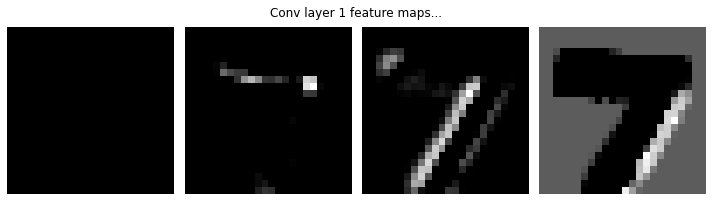

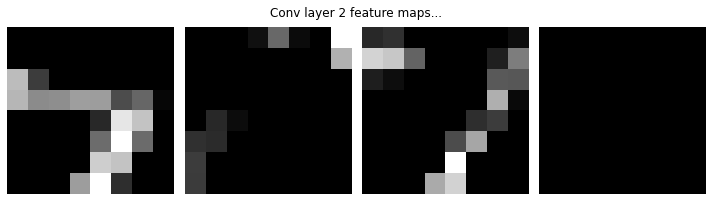

In [ ]:
# Visualize Feature Maps for Conv Layers
input_cnn = all_inputs[0]
cnn.eval()
with torch.no_grad():
  out, h1, h2 = cnn(input_cnn.unsqueeze(0))

# visualize 3 features from each layer 
for j, layer in enumerate([h1, h2]):
    fig = plt.figure(figsize=(10, 3))
    fig.suptitle(f"Conv layer {j + 1} feature maps...")
    # only visualize feature maps of first channel
    layer_viz = layer[0, :, :, :]
    layer_viz = layer_viz.data.cpu().float()
    for i, filter in enumerate(layer_viz):
        if i == 4: # visualize only 2x2 blocks from each layer
            break
        plt.subplot(1, 4, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    fig.tight_layout()
    plt.show()

for hook in hook_handles:
  hook.remove()

LABEL: 7; PRED: 7.0
LABEL: 2; PRED: 2.0
LABEL: 1; PRED: 1.0
LABEL: 0; PRED: 0.0
LABEL: 4; PRED: 4.0


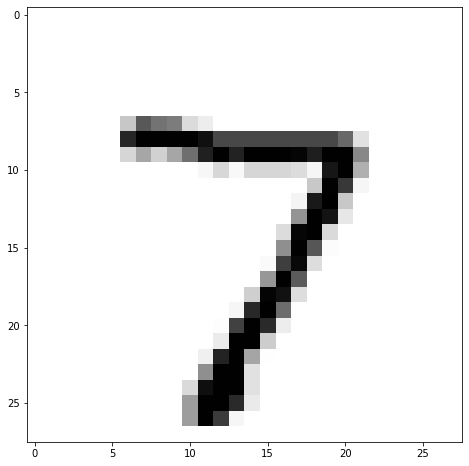

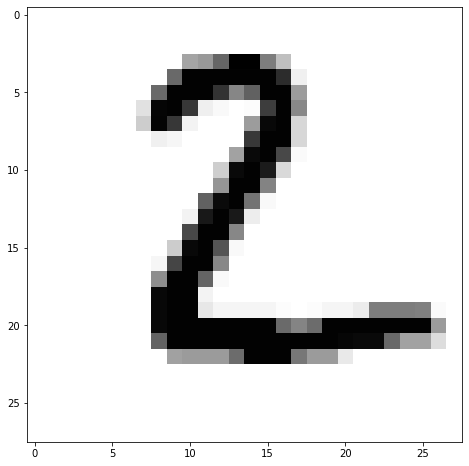

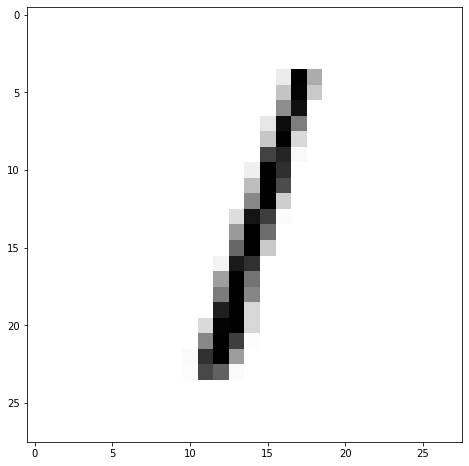

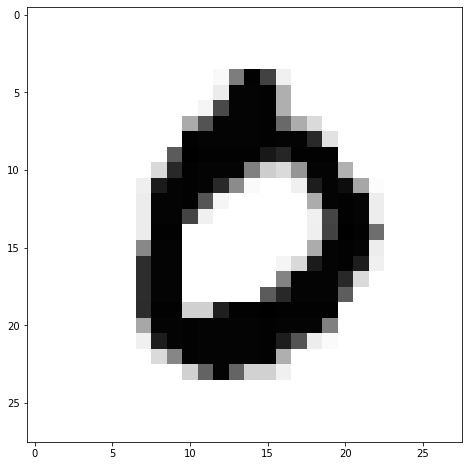

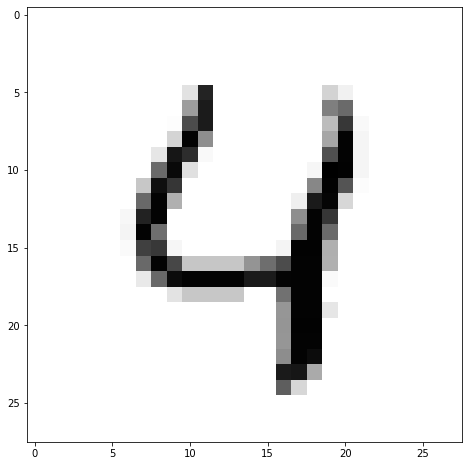

In [ ]:
# plot some results
# maybe of the first five images
# convert input back to 2d array
for input, output, label in zip(all_inputs[:5], all_output_classes[:5], all_labels[:5]):
  input = torch.reshape(input, (28, 28))
  ig = plt.figure(figsize=(8,8))
  input = input.cpu().numpy()
  plt.imshow(input, cmap='Greys')
  print(f"LABEL: {label}; PRED: {output}")